In [1]:
from helpers.utilities import *
%run helpers/notebook_setup.ipynb

In [2]:
%R source('plots/colors.R');

Inputs:

In [3]:
ensembl_to_entrez_path = 'data/ensembl_to_entrez.csv'
clinical_path = 'data/clean/clinical/data_with_derived_variables.csv'

raw_rna_path = 'data/clean/rna/all_samples_counts.csv'
raw_protein_path = 'data/clean/protein/gene_levels_by_entrez.csv'

rna_tmm_normalized_counts_path = 'data/preliminary_analyses/differential_rna_expression/normalized_counts/tmm_for_subsets.csv'

protein_tmm_normalized_counts_path = 'data/preliminary_analyses/differential_protein_levels/normalized_counts/tmm_for_subsets.csv'
protein_tmm_normalized_counts_gene_level_path = 'data/preliminary_analyses/differential_protein_levels/normalized_counts/gene_level_tmm_for_subsets.csv'

rna_rle_normalized_counts_path = 'data/preliminary_analyses/differential_rna_expression/normalized_counts/rle_for_subsets.csv'
protein_rle_normalized_counts_gene_level_path = 'data/preliminary_analyses/differential_protein_levels/normalized_counts/gene_level_rle_for_subsets.csv'

Outputs:

In [4]:
__outputs__ = create_paths(
    path='data/integration/',
    csv=['rna', 'rna_shared', 'protein', 'protein_shared', 'patients_with_both', 'genes_in_both', 'patient_annotations_ordered']
)

## Preprocessing, overlap analysis, gene-protein matching

For the majority of analyses I will use TMM normalized data (pre-filtered as for limma), mapped on the gene level:

In [5]:
rna_tmm_counts = read_csv(rna_tmm_normalized_counts_path, index_col=0)
protein_tmm_counts = read_csv(protein_tmm_normalized_counts_path, index_col=0)
protein_tmm_counts_gene_level = read_csv(protein_tmm_normalized_counts_gene_level_path, index_col=0)

In [6]:
rna_rle_counts = read_csv(rna_rle_normalized_counts_path, index_col=0)
protein_rle_counts_gene_level = read_csv(protein_rle_normalized_counts_gene_level_path, index_col=0)

While the raw RNASeq/SOMAScan data are hardly comparable, these are also useful to highlight possible discrepancies arising from technical issues:

In [7]:
raw_rna = read_csv(raw_rna_path, index_col=0)
raw_protein = read_csv(raw_protein_path, index_col=0)

In [8]:
raw_rna.head(2)

,001.TMD,006.CM,012.BM,016.CM,017.TMD,...,158.TMD,167.TMR,175.TMD,233.CM,261.CM
ENSG00000000003,1.0,3.0,2.0,16.0,25.0,...,0.0,0.0,0.0,0.0,25.0
ENSG00000000005,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,5.0


In [9]:
raw_protein.head(2)

,149.TMD,007.TMD,001.TMD,064.TMD,151.TMD,...,177.HC,189.HC,217.HC,221.HC,245.HC
10273,174.1,521.1,57.0,158.1,62.1,...,12.6,11.4,12.2,15.8,22.2
1051,53.3,283.6,36.1,126.6,33.7,...,10.4,9.7,9.6,11.0,15.1


### The patients overlap is limited and only present for CM, TM and Viral groups

In [10]:
from helpers.venn import venn2

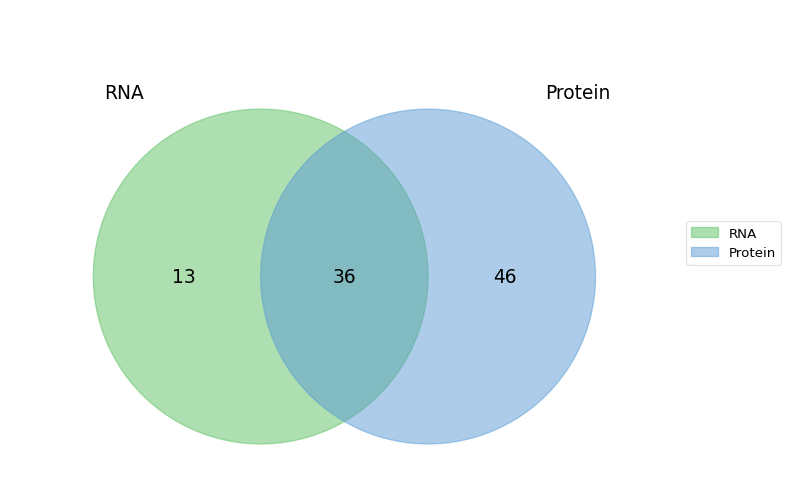

In [11]:
venn2(dict(RNA=rna_tmm_counts.columns, Protein=protein_tmm_counts.columns));

In [12]:
from numpy import nan
from math import log

In [13]:
patients_union = list(rna_tmm_counts.columns | protein_tmm_counts.columns)

assert all(raw_rna > 0) and all(raw_protein > 0)

patients_data = DataFrame(
    data=[{
            'Protein': log(sum(raw_protein[patient])) if patient in raw_protein else nan, 
            'RNA': log(sum(raw_rna[patient])) if patient in raw_rna else nan,
        }
        for patient in patients_union
    ],
    index=patients_union
).T

In [14]:
clinical = read_csv(clinical_path, index_col=0).loc[patients_union]
from plots.annotations import generate_patient_annotations
patient_annotations = generate_patient_annotations(clinical)

In [15]:
patient_annotations['Is RNA outlier'] = [
    patient in raw_rna and patient not in rna_tmm_counts.columns
    for patient in patients_union
]
assert any(patient_annotations['Is RNA outlier'])
patient_annotations.head(2)

,Meningitis,Tuberculosis status,HIV status,Is RNA outlier
PatientID,,,,
001.TMD,Tuberculosis,Definite,Positive,False
006.CM,Cryptococcal,-,Positive,False


In [16]:
patients_data

,001.TMD,006.CM,007.TMD,011.TMR,012.BM,...,247.CM,248.TMD,255.VM,256.CM,261.CM
Protein,16.692534,16.829547,17.15418,NaN,NaN,...,16.315459,17.097623,16.137170,16.604112,NaN
RNA,12.595934,14.060782,NaN,14.260128,15.175231,...,NaN,NaN,14.778364,15.188198,15.01611


In [17]:
joined = patient_annotations.join(patients_data.T)
joined['no_protein'] = joined['Protein'].isnull()
joined['no_rna'] = joined['RNA'].isnull()
ordered = joined.sort_values(['Meningitis', 'Tuberculosis status', 'no_protein', 'no_rna', 'Protein', 'RNA'])

In [18]:
patients_data_ordered = patients_data[ordered.index]
patient_annotations_ordered = patient_annotations.T[ordered.index].T

In [19]:
patient_annotations_ordered['Is RNA outlier'] = patient_annotations_ordered['Is RNA outlier'].astype(str)

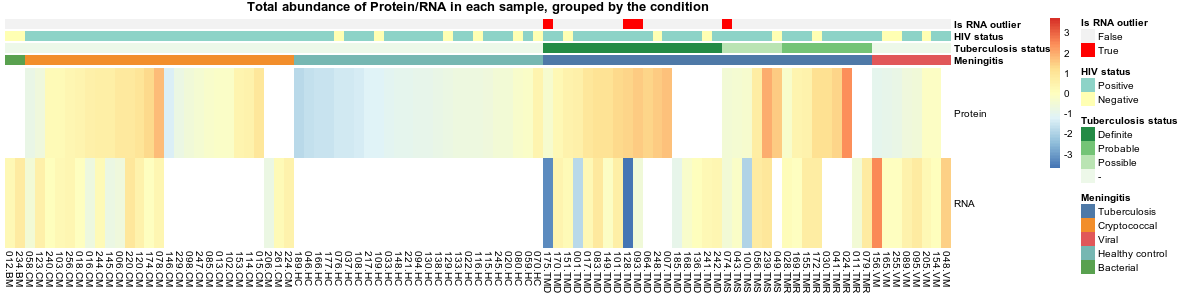

In [20]:
%%R -i patients_data_ordered -i patient_annotations_ordered -w 1200 -h 300
import::here(space_to_dot, dot_to_space, remove_leading_X, .from='helpers/utilities.R')
        
names(patient_annotations_ordered) = dot_to_space(names(patient_annotations_ordered))
colnames(patients_data_ordered) <- remove_leading_X(colnames(patients_data_ordered))

pheatmap::pheatmap(
    patients_data_ordered,
    show_colnames=T, show_rownames=T,
    annotation_col=patient_annotations_ordered,
    annotation_colors=patient_colors,
    cluster_rows=F, cluster_cols=F,
    scale='row',
    border_color='black', na_col='grey100',
    main='Total abundance of Protein/RNA in each sample, grouped by the condition'
)

## 2. Matching genes and proteins

Identifiers mapping:
 - there are multiple transcripts for the same gene (which may be due to different genomic loci or isoforms)
 - the simplest gene level analysis can use Entrez Gene IDs

### Using Entrez Gene ID

Gene-level protein counts are already mapped to Entrez Gene ID (here through UniProt, though aptamers metadata also have Entrez mappings):

In [21]:
protein_tmm_counts_gene_level.head(2)

,149.TMD,007.TMD,001.TMD,064.TMD,151.TMD,...,177.HC,189.HC,217.HC,221.HC,245.HC
10273,2.582776,2.984110,1.715378,2.136657,1.956247,...,1.035894,1.322431,1.144645,1.334694,1.113940
1051,0.929932,2.121968,1.082243,1.824437,1.106152,...,0.774224,1.099776,0.816865,0.837622,0.589689


Let's get Entrez Ids for RNA-seq results:

In [22]:
ensembl_to_entrez = read_csv(ensembl_to_entrez_path, index_col=0)
ensembl_to_entrez.head(2)

,NCBI Gene ID
Ensembl gene ID,
ENSG00000121410,1
ENSG00000268895,503538


In [23]:
rna_tmm_counts_entrez = copy(rna_tmm_counts)
rna_tmm_counts_entrez.index = rna_tmm_counts.index.map(ensembl_to_entrez['NCBI Gene ID'])
rna_tmm_counts_entrez.head(2)

,001.TMD,006.CM,012.BM,016.CM,017.TMD,...,174.CM,011.TMR,043.TMS,078.CM,261.CM
7105.0,1.732667,0.844989,0.100087,3.226129,3.224450,...,0.582407,3.286585,2.957586,-1.191528,2.771096
8813.0,-1.191528,2.553725,4.107589,-1.191528,4.725282,...,2.707083,1.283931,-1.191528,5.473760,3.667167


Unfortunately almost 30% genes have no mapping:

In [24]:
sum(rna_tmm_counts_entrez.index.isnull()) / len(rna_tmm_counts_entrez)

0.28585138469975324

NB: this likely affects our MsigDB-based pathways analyses

In [25]:
from helpers.venn import venn2

Despite that we get over 90% of overlap:

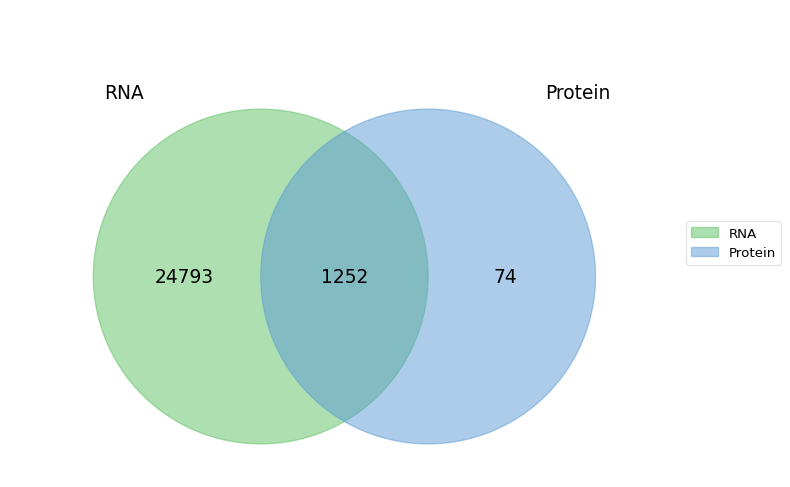

In [26]:
venn2(dict(RNA=rna_tmm_counts_entrez.index, Protein=protein_tmm_counts_gene_level.index));

### Using gene symbols:

In [27]:
protein_tmm_counts.head(2)

,149.TMD,007.TMD,001.TMD,064.TMD,151.TMD,...,177.HC,189.HC,217.HC,221.HC,245.HC
CHIP,2.554523,2.978964,1.698778,2.111255,1.934072,...,1.051758,1.301672,1.172738,1.378325,1.105333
CEBPB,0.902148,2.116709,1.065659,1.799091,1.084118,...,0.789761,1.079053,0.844422,0.880240,0.580928


In [28]:
from helpers.ensembl import Ensembl

ensembl = Ensembl(95)

In [29]:
ensembl_to_gene_name = ensembl.merge_gene_data(rna_tmm_counts)[['gene_name']]
ensembl_to_gene_name.head(2)

,gene_name
ENSG00000000003,TSPAN6
ENSG00000000419,DPM1


All identifiers in the RNA-Seq matrix got mapped:

In [30]:
assert set() == (set(ensembl_to_gene_name.index) - set(rna_tmm_counts.index))

And none of the mapped values is null:

In [31]:
assert not any(ensembl_to_gene_name['gene_name'].isnull())

In [32]:
rna_tmm_counts_names = copy(rna_tmm_counts)
rna_tmm_counts_names.index = rna_tmm_counts_names.index.map(lambda x: ensembl_to_gene_name['gene_name'].get(x, x))

#### Naive approach: using protein names

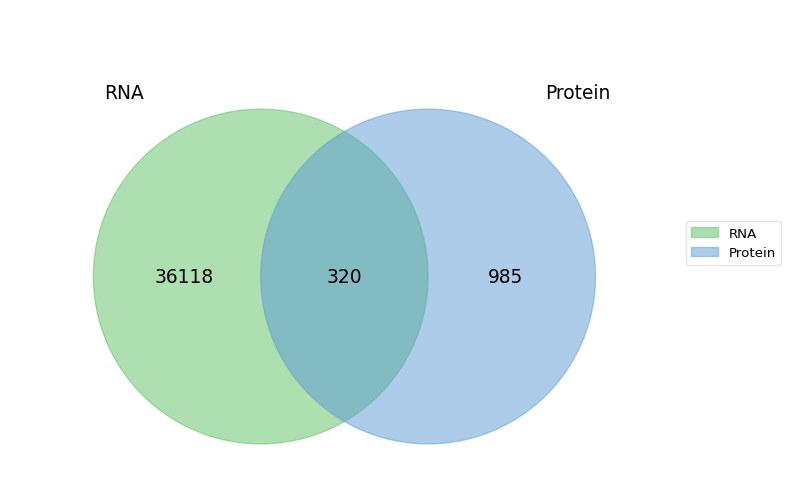

In [33]:
venn2(dict(RNA=rna_tmm_counts_names.index, Protein=protein_tmm_counts.index));

This is because on one side there are Ensembl provided HUGO-based names **gene** and on the other there are **protein** names, which do not have to be the same.

#### A better way: using entrez gene symbols mapping

In [34]:
id_to_symbol = read_table('data/hgnc/entrez_to_gene_symbol.tsv', index_col=0)['Approved symbol']

In [35]:
gene_symbols = Series(protein_tmm_counts_gene_level.index).apply(lambda x: id_to_symbol.get(x, nan))
sum(gene_symbols.isnull()) / len(gene_symbols)

0.00980392156862745

Finally, keep the old identifier rather than setting nan if no mapping found:

In [36]:
gene_symbols = Series(protein_tmm_counts_gene_level.index).apply(lambda x: id_to_symbol.get(x, x))

In [37]:
assert not gene_symbols.isnull().any()

In [38]:
# TODO isnull can be removed
protein_tmm_counts_names = protein_tmm_counts_gene_level.loc[list(~gene_symbols.isnull())]
protein_tmm_counts_names.index = list(gene_symbols[~gene_symbols.isnull()])
protein_tmm_counts_names.head(2)

,149.TMD,007.TMD,001.TMD,064.TMD,151.TMD,...,177.HC,189.HC,217.HC,221.HC,245.HC
STUB1,2.582776,2.984110,1.715378,2.136657,1.956247,...,1.035894,1.322431,1.144645,1.334694,1.113940
CEBPB,0.929932,2.121968,1.082243,1.824437,1.106152,...,0.774224,1.099776,0.816865,0.837622,0.589689


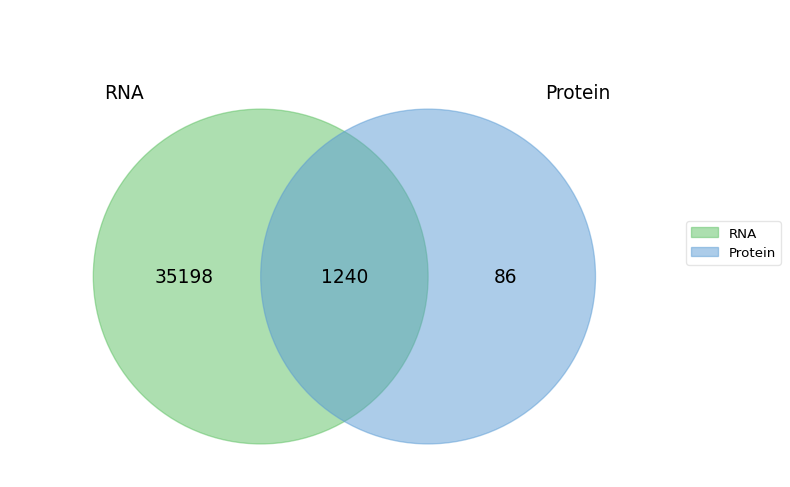

In [39]:
venn2(dict(RNA=rna_tmm_counts_names.index, Protein=protein_tmm_counts_names.index));

So I will use this one (there might be minor isofrorm level generalizations but it's also easier to interpret):

In [40]:
rna = rna_tmm_counts_names
protein = protein_tmm_counts_names

In [41]:
assert not any(rna.index.isnull())
assert not any(protein.index.isnull())

#### Same for RLE

In [42]:
rna_rle_counts_names = copy(rna_rle_counts)
rna_rle_counts_names.index = rna_rle_counts_names.index.map(ensembl_to_gene_name['gene_name'])

protein_rle_counts_names = protein_rle_counts_gene_level.loc[list(~gene_symbols.isnull())]
protein_rle_counts_names.index = list(gene_symbols[~gene_symbols.isnull()])

## Subsetting datasets

In [43]:
patients_with_both = Series(rna.columns & protein.columns)
genes_in_both = Series(rna.index & protein.index)

In [44]:
rna_shared = rna.loc[genes_in_both, patients_with_both]
protein_shared = protein.loc[genes_in_both, patients_with_both]

In [45]:
save_outputs(globals())